In [ ]:
!pip install pandas scikit-learn

✅ Đã lưu file: processed_ctgan_generated_faults.csv


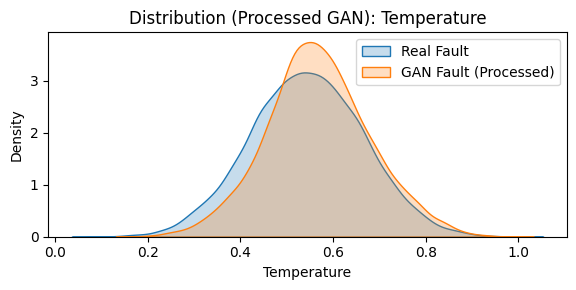

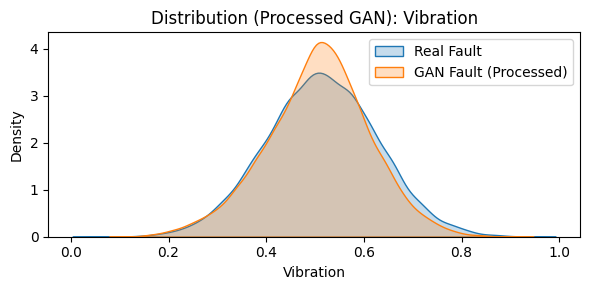

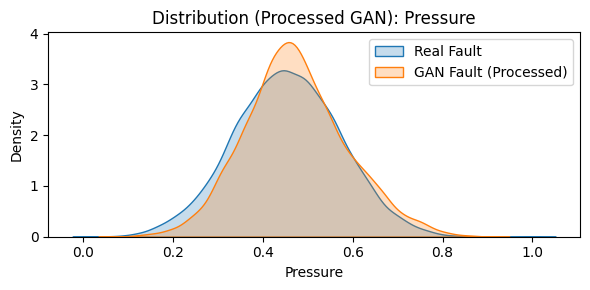

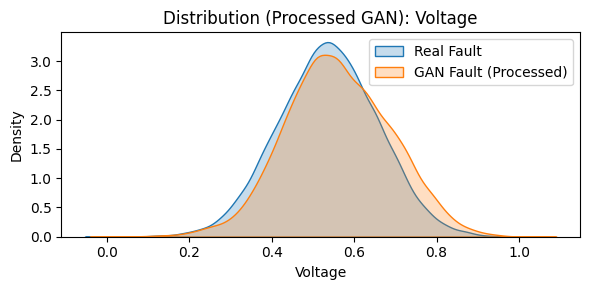

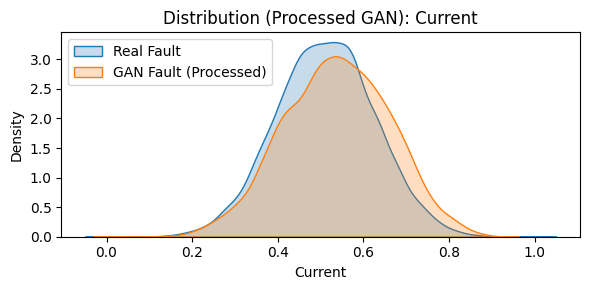

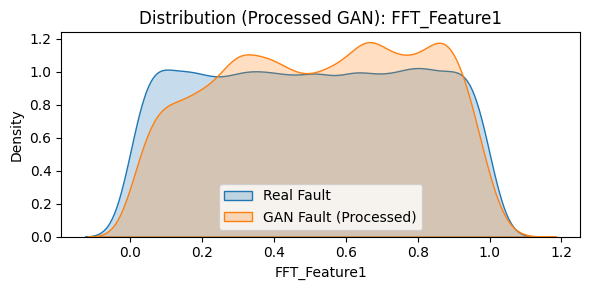

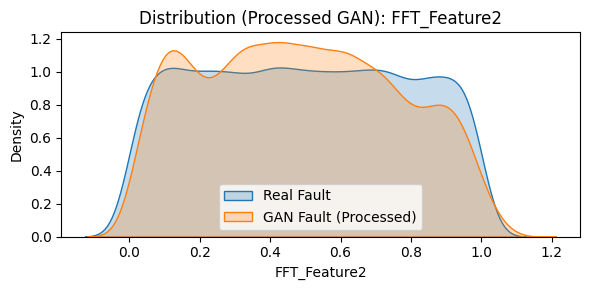

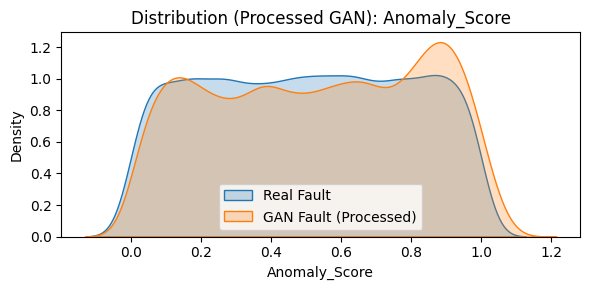

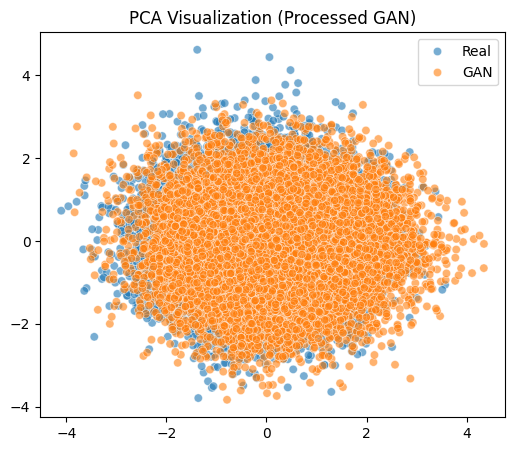

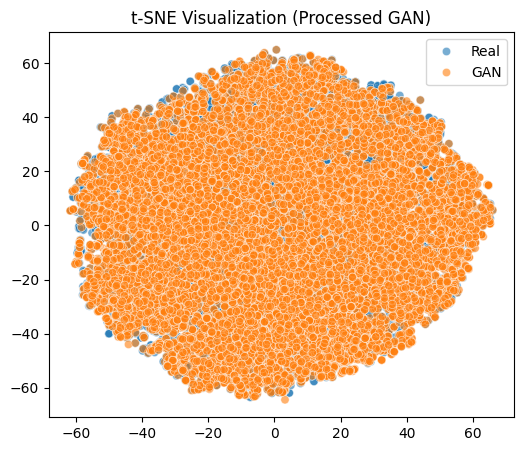


=== KL & JS Divergence between Real Faults and Processed GAN Faults ===
      Feature  KL_Divergence  JS_Divergence
  Temperature       0.049950       0.008874
    Vibration       0.024328       0.003951
     Pressure       0.034292       0.006382
      Voltage       0.026315       0.006862
      Current       0.040682       0.009350
 FFT_Feature1       0.027719       0.006527
 FFT_Feature2       0.025673       0.005960
Anomaly_Score       0.012675       0.003115
✅ Đã lưu file: full_dataset_with_gan.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

# ==== 1. Load and Clean Data ====
df_real = pd.read_csv("/content/processed_iot_dataset.csv")
df_gan_raw = pd.read_csv("/content/ctgan_generated_faults_by_type_with_time.csv")

df_real = df_real.drop_duplicates().dropna()
df_gan_raw = df_gan_raw.drop_duplicates().dropna()

# ==== 2. Define Sensor Columns ====
sensor_cols = [
    'Temperature', 'Vibration', 'Pressure', 'Voltage', 'Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]

# ==== 3. Filter out negative values from GAN and save processed file ====
df_gan_processed = df_gan_raw[(df_gan_raw[sensor_cols] >= 0).all(axis=1)].copy()
df_gan_processed.to_csv("/content/processed_ctgan_generated_faults.csv", index=False)
print("✅ Đã lưu file: processed_ctgan_generated_faults.csv")

# ==== 4. Filter only faults from both datasets ====
df_real_fault = df_real[df_real['Fault_Status'] == 1].copy()
df_gan_fault = df_gan_processed[df_gan_processed['Fault_Status'] == 1].copy()

# ==== 5. Visualize Distributions ====
for col in sensor_cols:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(df_real_fault[col], label='Real Fault', fill=True)
    sns.kdeplot(df_gan_fault[col], label='GAN Fault (Processed)', fill=True)
    plt.title(f'Distribution (Processed GAN): {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== 6. PCA and t-SNE ====
scaler = StandardScaler()
real_scaled = scaler.fit_transform(df_real_fault[sensor_cols])
gan_scaled = scaler.transform(df_gan_fault[sensor_cols])

combined = np.vstack([real_scaled, gan_scaled])
labels = np.array(["Real"] * len(df_real_fault) + ["GAN"] * len(df_gan_fault))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, alpha=0.6)
plt.title("PCA Visualization (Processed GAN)")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, alpha=0.6)
plt.title("t-SNE Visualization (Processed GAN)")
plt.show()

# ==== 7. KL & JS Divergence ====
def compute_kl_js(real, fake):
    kl_div = entropy(real + 1e-9, fake + 1e-9)
    js_div = jensenshannon(real + 1e-9, fake + 1e-9)**2
    return kl_div, js_div

results = []
for col in sensor_cols:
    real_hist, bins = np.histogram(df_real_fault[col], bins=50, range=(df_real_fault[col].min(), df_real_fault[col].max()), density=True)
    fake_hist, _ = np.histogram(df_gan_fault[col], bins=bins, density=True)
    kl, js = compute_kl_js(real_hist, fake_hist)
    results.append({"Feature": col, "KL_Divergence": kl, "JS_Divergence": js})

div_df = pd.DataFrame(results)
print("\n=== KL & JS Divergence between Real Faults and Processed GAN Faults ===")
print(div_df.to_string(index=False))

# ==== 8. Merge full dataset (Real + Processed GAN) ====
df_combined = pd.concat([df_real, df_gan_processed], ignore_index=True)
df_combined = df_combined.drop_duplicates().reset_index(drop=True)
df_combined.to_csv("/content/full_dataset_with_gan.csv", index=False)
print("✅ Đã lưu file: full_dataset_with_gan.csv")
